<a href="https://colab.research.google.com/github/fkaimphilat/compling_hse/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 8

In [50]:
!pip install pandas scikit-learn matplotlib

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import tensorflow as tf

In [53]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
data = pd.read_csv('/content/drive/MyDrive/hse_nlp_PHILATOV/lenta_40k.csv.zip')

In [55]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [56]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [57]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [58]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [59]:
len(vocab)

354611

In [60]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [61]:
len(filtered_vocab)

24091

In [62]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [63]:
id2word = {i:word for word, i in word2id.items()}

In [64]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [65]:
MAX_LEN = max(len(x) for x in X)

In [66]:
MEAN_LEN = np.median([len(x) for x in X])

In [67]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [68]:
MAX_LEN = int(MEAN_LEN + 30)

In [69]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [70]:
X.shape

(44356, 200)

In [71]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [72]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [73]:
len(label2id)

19

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

## Задание 1 (4 балла) 

In [75]:
data.dropna(subset=['topic', 'text'], inplace=True)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

**Один GRU слой**

In [76]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [77]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 37s 63ms/step - loss: 2.5736 - f1: 0.0049 - rec@prec: 0.0000e+00 - val_loss: 2.3269 - val_f1: 0.0000e+00 - val_rec@prec: 0.0023
Epoch 2/20
43/43 [==============================] - 2s 48ms/step - loss: 2.2833 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2415 - val_f1: 0.0000e+00 - val_rec@prec: 0.0023
Epoch 3/20
43/43 [==============================] - 2s 48ms/step - loss: 2.1186 - f1: 0.0044 - rec@prec: 5.9329e-04 - val_loss: 2.0733 - val_f1: 0.0375 - val_rec@prec: 0.0023
Epoch 4/20
43/43 [==============================] - 2s 49ms/step - loss: 1.8513 - f1: 0.0736 - rec@prec: 0.0259 - val_loss: 2.0241 - val_f1: 0.1554 - val_rec@prec: 0.0036
Epoch 5/20
43/43 [==============================] - 2s 49ms/step - loss: 1.6892 - f1: 0.2268 - rec@prec: 0.1061 - val_loss: 1.7442 - val_f1: 0.2290 - val_rec@prec: 0.0383
Epoch 6/20
43/43 [==============================] - 2s 49ms/step - loss: 1.4885 - f1: 0.3589 - rec@prec: 0.2130 - val_lo

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


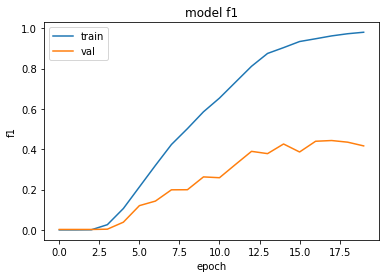

In [78]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Один LSTM слой**

In [79]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn1 = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [80]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 5s 70ms/step - loss: 2.4983 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3216 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 2s 56ms/step - loss: 2.3141 - f1: 0.0000e+00 - rec@prec: 1.1866e-04 - val_loss: 2.2993 - val_f1: 0.0000e+00 - val_rec@prec: 4.5086e-04
Epoch 3/20
43/43 [==============================] - 2s 57ms/step - loss: 2.2429 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.0754 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/20
43/43 [==============================] - 2s 57ms/step - loss: 1.9334 - f1: 0.0146 - rec@prec: 0.0252 - val_loss: 1.8250 - val_f1: 0.0973 - val_rec@prec: 0.0757
Epoch 5/20
43/43 [==============================] - 2s 57ms/step - loss: 1.6312 - f1: 0.2436 - rec@prec: 0.1358 - val_loss: 1.6816 - val_f1: 0.3309 - val_rec@prec: 0.1262
Epoch 6/20
43/43 [==============================] - 2s 57ms/step - loss: 1.4084 - f1: 0.4539 - re

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


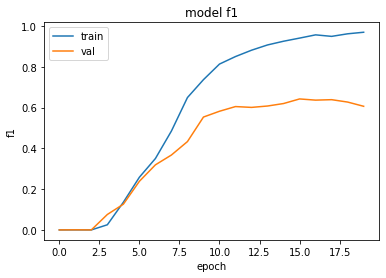

In [81]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Один GRU слой и один LSTM слой**

In [82]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru0 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm0 = tf.keras.layers.LSTM(128, return_sequences=False)(gru0)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm0)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [83]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 8s 130ms/step - loss: 2.4575 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3030 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 5s 113ms/step - loss: 2.1129 - f1: 0.0022 - rec@prec: 0.0010 - val_loss: 1.8967 - val_f1: 0.0384 - val_rec@prec: 0.0230
Epoch 3/20
43/43 [==============================] - 5s 113ms/step - loss: 1.7463 - f1: 0.1144 - rec@prec: 0.0603 - val_loss: 1.7508 - val_f1: 0.1228 - val_rec@prec: 0.0739
Epoch 4/20
43/43 [==============================] - 5s 113ms/step - loss: 1.6238 - f1: 0.1761 - rec@prec: 0.1005 - val_loss: 1.6856 - val_f1: 0.1932 - val_rec@prec: 0.1204
Epoch 5/20
43/43 [==============================] - 5s 114ms/step - loss: 1.4573 - f1: 0.3091 - rec@prec: 0.1820 - val_loss: 1.6327 - val_f1: 0.2639 - val_rec@prec: 0.1443
Epoch 6/20
43/43 [==============================] - 5s 114ms/step - loss: 1.3292 - f1: 0.4119 - rec@prec: 0.2451 - val_loss:

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


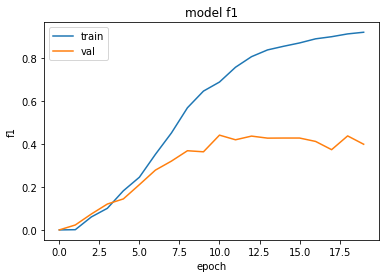

In [84]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Один BIGRU слой и два LSTM слоя**

In [85]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm1_0 = tf.keras.layers.LSTM(128, return_sequences=True)(bigru1)
lstm1_1 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm1_0)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm1_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [86]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 17s 277ms/step - loss: 2.4237 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3194 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 11s 251ms/step - loss: 2.2792 - f1: 0.0166 - rec@prec: 2.3732e-05 - val_loss: 2.1197 - val_f1: 0.1327 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 11s 253ms/step - loss: 1.8967 - f1: 0.1800 - rec@prec: 0.0514 - val_loss: 1.6932 - val_f1: 0.2418 - val_rec@prec: 0.1389
Epoch 4/20
43/43 [==============================] - 11s 254ms/step - loss: 1.5031 - f1: 0.3967 - rec@prec: 0.1859 - val_loss: 1.4457 - val_f1: 0.5057 - val_rec@prec: 0.2245
Epoch 5/20
43/43 [==============================] - 11s 256ms/step - loss: 1.2527 - f1: 0.5823 - rec@prec: 0.3247 - val_loss: 1.4032 - val_f1: 0.5454 - val_rec@prec: 0.2759
Epoch 6/20
43/43 [==============================] - 11s 257ms/step - loss: 1.1104 - f1: 0.6402 - rec@prec: 0.46

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


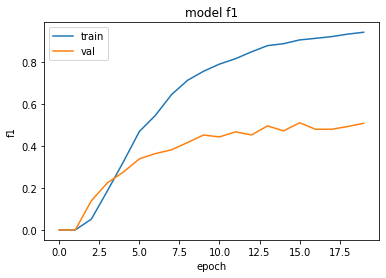

In [87]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Пять GRU слоев и три LSTM слоя**

In [88]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru2_0 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru2_1 = tf.keras.layers.GRU(128, return_sequences=True)(gru2_0)
gru2_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru2_1)
gru2_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru2_2)
gru2_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru2_3)

lstm2_0 = tf.keras.layers.LSTM(128, return_sequences=True)(gru2_4)
lstm2_1 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm2_0)
lstm2_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm2_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm2_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [89]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 32s 516ms/step - loss: 2.3950 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3207 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 20s 469ms/step - loss: 2.3237 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3215 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 [==============================] - 20s 471ms/step - loss: 2.3242 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3209 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/20
43/43 [==============================] - 20s 474ms/step - loss: 2.3242 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3213 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/20
43/43 [==============================] - 20s 477ms/step - loss: 2.3226 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3202 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/20
43/43 [==============================] - 21s

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


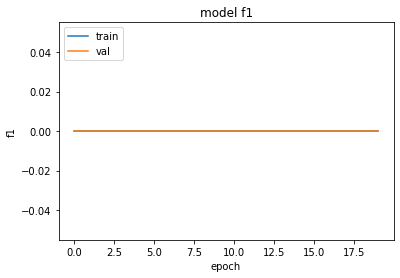

In [90]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Один BIGRU слой и один BILSTM слой (разные модели для forward и backward проходов)**

In [91]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru_fw = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=True),
    backward_layer=tf.keras.layers.GRU(32, return_sequences=True, go_backwards=True)
    )(embeddings)

bilstm_bw = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(128, return_sequences=False),
    backward_layer=tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True)
    )(bigru_fw)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bilstm_bw)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [92]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 17s 281ms/step - loss: 2.4334 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3017 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 10s 242ms/step - loss: 2.1360 - f1: 0.0047 - rec@prec: 0.0000e+00 - val_loss: 1.8935 - val_f1: 0.0110 - val_rec@prec: 0.0365
Epoch 3/20
43/43 [==============================] - 11s 246ms/step - loss: 1.7141 - f1: 0.1779 - rec@prec: 0.0495 - val_loss: 1.6174 - val_f1: 0.3036 - val_rec@prec: 0.1317
Epoch 4/20
43/43 [==============================] - 11s 246ms/step - loss: 1.3898 - f1: 0.4644 - rec@prec: 0.2596 - val_loss: 1.4474 - val_f1: 0.5446 - val_rec@prec: 0.3242
Epoch 5/20
43/43 [==============================] - 10s 244ms/step - loss: 1.1801 - f1: 0.6142 - rec@prec: 0.4605 - val_loss: 1.4059 - val_f1: 0.5240 - val_rec@prec: 0.3476
Epoch 6/20
43/43 [==============================] - 10s 243ms/step - loss: 1.0443 - f1: 0.6563 - rec@prec: 0.5556 -

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


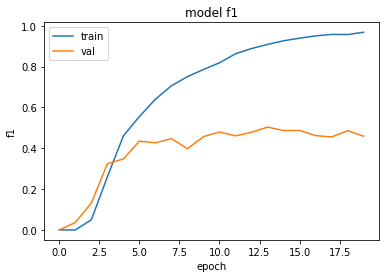

In [93]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**LSTM--GRU--BILSTM--BIGRU--GRU--LSTM**

In [94]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm3_0 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru3_0 = tf.keras.layers.GRU(128, return_sequences=True)(lstm3_0)

bilstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(gru3_0) 
bigru3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bilstm3)

gru3_1 = tf.keras.layers.GRU(128, return_sequences=True)(bigru3)
lstm3_1 = tf.keras.layers.LSTM(128, return_sequences=False)(gru3_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm3_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [95]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 [==============================] - 36s 627ms/step - loss: 2.3992 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3221 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 [==============================] - 25s 587ms/step - loss: 2.1950 - f1: 0.0036 - rec@prec: 0.0012 - val_loss: 1.9114 - val_f1: 0.0134 - val_rec@prec: 0.0261
Epoch 3/20
43/43 [==============================] - 25s 577ms/step - loss: 1.7225 - f1: 0.1542 - rec@prec: 0.0698 - val_loss: 1.6999 - val_f1: 0.2316 - val_rec@prec: 0.0879
Epoch 4/20
43/43 [==============================] - 25s 577ms/step - loss: 1.5460 - f1: 0.3350 - rec@prec: 0.1204 - val_loss: 1.7176 - val_f1: 0.3577 - val_rec@prec: 0.0748
Epoch 5/20
43/43 [==============================] - 25s 582ms/step - loss: 1.4806 - f1: 0.4084 - rec@prec: 0.1250 - val_loss: 1.6877 - val_f1: 0.3938 - val_rec@prec: 0.1204
Epoch 6/20
43/43 [==============================] - 25s 580ms/step - loss: 1.3877 - f1: 0.4890 - rec@prec: 0.1520 - val

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


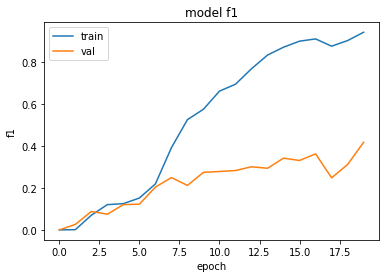

In [96]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Лучше всего себя показала модель с пятью GRU слоями и тремя LSTM слоями**

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [97]:
!ls 

drive  navec_hudlit_v1_12B_500K_300d_100q.tar  sample_data


In [98]:
!pip install navec

In [99]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2022-05-22 21:20:02--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’

navec_hudlit_v1_12B 100%[===================>]  50.56M  18.2MB/s    in 2.8s    

2022-05-22 21:20:05 (18.2 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’ saved [53012480/53012480]



In [100]:
!pip install slovnet

In [101]:
!pip install datasets

In [102]:
from datasets import load_dataset
dataset = load_dataset("wikiann", 'ru')

Reusing dataset wikiann (/root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e)


  0%|          | 0/3 [00:00<?, ?it/s]

In [103]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [104]:
import os
from navec import Navec
from slovnet.model.emb import NavecEmbedding

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(os.path.join('/content/', path))
emb = NavecEmbedding(navec)

In [105]:
weights = np.zeros((len(word2id), 300))

for word, id in word2id.items():
  if word != 'PAD':
    try:
      weights[id] = emb(np.asarray(navec.vocab[id2word[id]]))
    except KeyError:
      weights[id] = navec.vocab['<unk>']
 

In [106]:
weights

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.00000000e+05,  5.00000000e+05,  5.00000000e+05, ...,
         5.00000000e+05,  5.00000000e+05,  5.00000000e+05],
       [-3.37472856e-01,  5.52584112e-01,  4.55856115e-01, ...,
        -9.18868408e-02, -6.79565370e-02, -6.04499280e-01],
       ...,
       [ 5.00000000e+05,  5.00000000e+05,  5.00000000e+05, ...,
         5.00000000e+05,  5.00000000e+05,  5.00000000e+05],
       [ 5.00000000e+05,  5.00000000e+05,  5.00000000e+05, ...,
         5.00000000e+05,  5.00000000e+05,  5.00000000e+05],
       [ 5.00000000e+05,  5.00000000e+05,  5.00000000e+05, ...,
         5.00000000e+05,  5.00000000e+05,  5.00000000e+05]])

In [107]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                       trainable=False,
                                       weights=[weights])(inputs, )

bilstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
bilstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(bilstm1)
bilstm3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(bilstm2)
bilstm4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(bilstm3)
bilstm5 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(bilstm4)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bilstm5)

bilstm_model = tf.keras.Model(inputs=inputs, outputs=outputs)
bilstm_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])


Epoch 1/5
157/157 [==============================] - 35s 84ms/step - loss: 0.1983 - accuracy: 0.9418 - val_loss: 0.1276 - val_accuracy: 0.9582
Epoch 2/5
157/157 [==============================] - 10s 65ms/step - loss: 0.1053 - accuracy: 0.9650 - val_loss: 0.0927 - val_accuracy: 0.9694
Epoch 3/5
157/157 [==============================] - 10s 66ms/step - loss: 0.0705 - accuracy: 0.9777 - val_loss: 0.0695 - val_accuracy: 0.9785
Epoch 4/5
157/157 [==============================] - 10s 65ms/step - loss: 0.0519 - accuracy: 0.9839 - val_loss: 0.0603 - val_accuracy: 0.9808
Epoch 5/5
157/157 [==============================] - 10s 65ms/step - loss: 0.0441 - accuracy: 0.9862 - val_loss: 0.0563 - val_accuracy: 0.9819
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


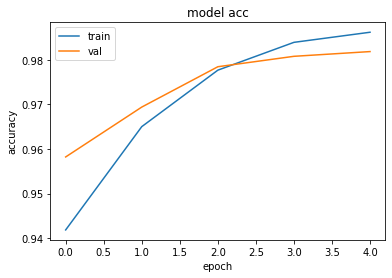

In [108]:
bilstm_model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

print(bilstm_model.history.history.keys())
plt.plot(bilstm_model.history.history['accuracy'])
plt.plot(bilstm_model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [109]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [116]:
label_seq('В Питер никогда волк уезжать жить красиво в доме на березовом саду не хотел', word2id, id2labels, MAX_LEN, bilstm_model)

[('В', 'O'),
 ('Питер', 'B-LOC'),
 ('никогда', 'O'),
 ('волк', 'O'),
 ('уезжать', 'O'),
 ('жить', 'O'),
 ('красиво', 'O'),
 ('в', 'O'),
 ('доме', 'O'),
 ('на', 'O'),
 ('березовом', 'B-LOC'),
 ('саду', 'I-LOC'),
 ('не', 'O'),
 ('хотел', 'O')]

In [118]:
label_seq('Ислам вышел из метро на Киевской в сторону Кутузовского', word2id, id2labels, MAX_LEN, bilstm_model)

[('Ислам', 'O'),
 ('вышел', 'O'),
 ('из', 'O'),
 ('метро', 'B-LOC'),
 ('на', 'O'),
 ('Киевской', 'B-LOC'),
 ('в', 'O'),
 ('сторону', 'O'),
 ('Кутузовского', 'O')]

In [111]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300, 
                                       trainable=False,
                                       weights=[weights])(inputs, )

bigru1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru1)
bigru3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru2)
bigru4 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru3)
bigru5 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru4)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bigru5)

bigru_model = tf.keras.Model(inputs=inputs, outputs=outputs)
bigru_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

Epoch 1/5
157/157 [==============================] - 23s 72ms/step - loss: 0.1680 - accuracy: 0.9549 - val_loss: 0.0895 - val_accuracy: 0.9723
Epoch 2/5
157/157 [==============================] - 9s 55ms/step - loss: 0.0628 - accuracy: 0.9803 - val_loss: 0.0635 - val_accuracy: 0.9796
Epoch 3/5
157/157 [==============================] - 9s 56ms/step - loss: 0.0504 - accuracy: 0.9841 - val_loss: 0.0612 - val_accuracy: 0.9806
Epoch 4/5
157/157 [==============================] - 9s 56ms/step - loss: 0.0441 - accuracy: 0.9860 - val_loss: 0.0570 - val_accuracy: 0.9827
Epoch 5/5
157/157 [==============================] - 9s 57ms/step - loss: 0.0389 - accuracy: 0.9876 - val_loss: 0.0533 - val_accuracy: 0.9830
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


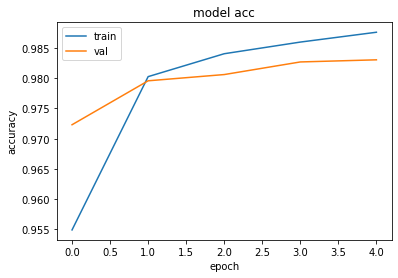

In [112]:
bigru_model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

print(bigru_model.history.history.keys())
plt.plot(bigru_model.history.history['accuracy'])
plt.plot(bigru_model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [115]:
label_seq('В Питер никогда волк уезжать жить красиво в доме на березовом саду не хотел', word2id, id2labels, MAX_LEN, bigru_model)

[('В', 'O'),
 ('Питер', 'B-PER'),
 ('никогда', 'O'),
 ('волк', 'O'),
 ('уезжать', 'O'),
 ('жить', 'O'),
 ('красиво', 'O'),
 ('в', 'O'),
 ('доме', 'O'),
 ('на', 'O'),
 ('березовом', 'B-ORG'),
 ('саду', 'I-ORG'),
 ('не', 'O'),
 ('хотел', 'O')]

In [120]:
label_seq('Ислам вышел из метро на Киевской в сторону Кутузовского', word2id, id2labels, MAX_LEN, bigru_model)

[('Ислам', 'O'),
 ('вышел', 'O'),
 ('из', 'O'),
 ('метро', 'B-ORG'),
 ('на', 'O'),
 ('Киевской', 'B-LOC'),
 ('в', 'I-ORG'),
 ('сторону', 'O'),
 ('Кутузовского', 'O')]

Обе модели работают очень плохо, но есть подозрение, что все дело в эмбеддингах.